# PyTorch - Autograd (is what we need.)

Advanced Learning 2025





For SUBMISSION:  
  
Please upload the complete and executed `ipynb` to your git repository. Verify that all of your output can be viewed directly from github, and provide a link to that git file below.

~~~
STUDENT ID: 314992595
~~~

~~~
STUDENT GIT LINK: https://github.com/netanelazran11
~~~

In Addition, don't forget to add your ID to the files:  
`PS1_Part3_Autograd_2025_ID_[000000000].html`  



This part of the problem-set is divided into 2 sections: (a) a short introduction to PyTorch autograd, and (b) some practice questions.      
The practice questions cover calculating the gradients and updating the weights of a statistical model (linear regression), with and without PyTorch autograd.

##  A Short Intro to PyTorch Autograd

In PyTorch, autograd, short for automatic differentiation, is a core functionality that empowers you to efficiently calculate gradients during deep learning model training. It acts as a computational engine that automatically tracks the operations performed on your tensors and calculates the gradients of any loss function with respect to the model's learnable parameters.

**Why is Autograd Important?**

* Gradient Calculation: Deep learning relies heavily on gradient-based optimization algorithms like stochastic gradient descent (SGD). These algorithms adjust the weights and biases (learnable parameters) of your model based on the gradients of the loss function. Autograd automates this process, saving you from manually calculating complex derivatives.
* Efficient Backpropagation: Backpropagation is the algorithm at the heart of training deep neural networks. It propagates the error (loss) backward through the network, allowing the model to adjust its parameters in the direction that minimizes the loss. Autograd streamlines this process, making training more efficient.

**How Does Autograd Work?**

* Tracking Operations: When you enable autograd mode (with `torch.autograd.record_grad()`), PyTorch creates a computational graph in the background. This graph tracks all the operations performed on your tensors

* Backward Pass: Once you calculate a loss function (which typically depends on the output of your model), you can call the `backward()` method on the loss tensor. This triggers the backward pass through the computational graph.

* Gradient Calculation: As the backward pass traverses the graph, autograd computes the gradients of the loss function with respect to each learnable parameter in the network. These gradients indicate how much a specific parameter contributed to the overall loss.

* Parameter Update: By utilizing these gradients, optimization algorithms like SGD update the model's learnable parameters in a direction that minimizes the loss function. This iterative process continues until the model converges (achieves a desired level of performance).

**Key Points about Autograd:**

* Automatic
* Only for Learnable Parameters: Autograd tracks gradients only for tensors that have `requires_grad=True`.
* Dynamic vs. Static Graphs (Optional): PyTorch offers both dynamic computational graphs (eager execution) and static graphs (graph mode) for model development.



In [2]:
import time
import numpy as np
import pandas as pd
import torch
import math
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader

In [3]:

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
print(f"Using {device}!")


Using cpu!


##  0. Loading data and defining our model and loss

Load the California Housing Market dataset into a panda's DataFrame.  
In addition, scale the data (why?).

In [4]:
# Import the dataset.
cali_train_path = "https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv"
train_df = pd.read_csv(filepath_or_buffer=cali_train_path).drop(['longitude','latitude'],axis=1)
train_df_norm=(train_df-train_df.mean(axis=0))/train_df.std(axis=0) # column-wise operators
# Scale the labels:
print(f"Dataset dimension: {train_df_norm.shape}")
train_df_norm.head()

Dataset dimension: (17000, 7)


housing_median_age  total_rooms  total_bedrooms  population  households  \
0           -1.079639     1.361655        1.764152   -0.361173   -0.075996   
1           -0.761850     2.296540        3.230346   -0.261858   -0.099401   
2           -0.920744    -0.882436       -0.866931   -0.955326   -0.999223   
3           -1.159087    -0.524171       -0.480216   -0.796769   -0.715753   
4           -0.682402    -0.545731       -0.506313   -0.701809   -0.622130   

   median_income  median_house_value  
0      -1.252506           -1.210522  
1      -1.081451           -1.096713  
2      -1.170071           -1.048430  
3      -0.362590           -1.154480  
4      -1.026424           -1.222593

We define a linear model to fit the scaled median house value to our data:  

**Our model :**.    

 $$\text{median_house_value}_i=y_i = \beta_0+	\beta_1\text{housing_median_age}_i+ 	\beta_2\text{total_rooms}_i+ 	\beta_3\text{total_bedrooms}_i+ 	\beta_4\text{population}_i+ 	\beta_5\text{households}_i+ 	\beta_6\text{median_income}_i 	$$

**Our loss :**  
$$
\hat{L}_i(y_i,\hat{y}_i) = MSE(\text{y}_i,\hat{\text{y}}_i)
$$


## 1.  Manually Calculating the Gradients and Updating the Weights



Here we take a step back, and implement forward and backward propogation manually (so we can fully appreciate the autograd later...).

First, create numpy arrays for our data (X) and target (Y):

In [10]:
X = train_df_norm.drop(['median_house_value'],axis=1).to_numpy()
X =  np.c_[  np.ones(X.shape[0]), X ] # adding a column of "1"s for intercept
Y = train_df_norm['median_house_value']
df = pd.DataFrame(X)
print(df)
print(f"X dimension: {X.shape}")
print(f"Y dimension: {Y.shape}")

         0         1         2         3         4         5         6
0      1.0 -1.079639  1.361655  1.764152 -0.361173 -0.075996 -1.252506
1      1.0 -0.761850  2.296540  3.230346 -0.261858 -0.099401 -1.081451
2      1.0 -0.920744 -0.882436 -0.866931 -0.955326 -0.999223 -1.170071
3      1.0 -1.159087 -0.524171 -0.480216 -0.796769 -0.715753 -0.362590
4      1.0 -0.682402 -0.545731 -0.506313 -0.701809 -0.622130 -1.026424
...    ...       ...       ...       ...       ...       ...       ...
16995  1.0  1.859916 -0.195722 -0.344985 -0.455262 -0.343862 -0.799975
16996  1.0  0.588757 -0.135170 -0.027072 -0.205230 -0.094200 -0.715705
16997  1.0 -0.920744  0.015292 -0.019955 -0.161670 -0.117606 -0.446650
16998  1.0 -0.761850  0.012998  0.029868 -0.114626 -0.060392 -0.997758
16999  1.0  1.859916 -0.377837 -0.567998 -0.543252 -0.601325 -0.455349

[17000 rows x 7 columns]
X dimension: (17000, 7)
Y dimension: (17000,)


### 1.1 Calculating the weights analytically (15pts)
Apply linear algebra operations to `X` and `Y` to analytically solve the linear regression problem (solve for `W`).   
Please use only numpy. Round the weights to 3 decimal places.  

In [11]:
#### SOLUTION REQUIRED ####
t1 = time.time()

weights = np.linalg.inv(X.T@X) @ X.T @ Y
weights_rounded = np.round(weights)
print(f"Total process time: {round(time.time() - t1,3)}")
print(f"The estimated weights using the analytic solution:\n {weights_rounded.round(3)}")

Total process time: 0.006
The estimated weights using the analytic solution:
 [ 0.  0. -0.  0. -0.  0.  1.]


Visualizing the errors:

/var/folders/59/3mc76c656n75_1mxr9_glqw80000gn/T/ipykernel_59038/1668682842.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


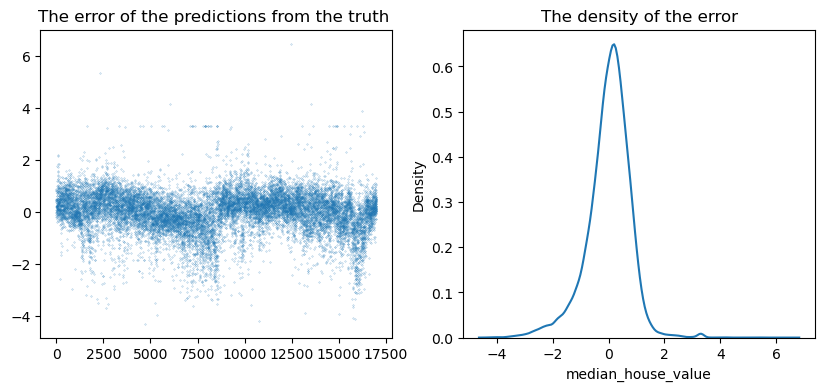

In [12]:
# Plot the errors and density (sanity check):
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10,4))
error = (np.matmul( X, weights_rounded)-Y)
ax1.scatter(range(Y.shape[0]), error ,s=0.05,alpha=0.7)
ax1.set_title("The error of the predictions from the truth ")
sns.kdeplot(error,ax=ax2)
ax2.set_title("The density of the error")
fig.show()


### 1.2 Calculating the weights using numpy and gradient descent (30pts)

Now you are ready to implement an algorithm that iteratively calculates the weights using numpy and gradient descent.

Please fill in your code in the `### YOUR CODE HERE` sections in the code block below.   
Please don't change the other parts of the code (unless specified).  

An epoch in machine learning means one complete pass of the training dataset through the algorithm.   

While developing your code, you may reduce the number of epochs.   
However, for final output please use the pre-defined epochs number.      





In [14]:
#### SOLUTION REQUIRED ####

t2 = time.time()

# Randomly initialize weights using numpy
b0 = np.random.randn()
b1 = np.random.randn()
b2 = np.random.randn()
b3 = np.random.randn()
b4 = np.random.randn()
b5 = np.random.randn()
b6 = np.random.randn()

# Set learning rate (this can be a little fiddly, requires some tunning)
# Tip: start with a very small steps...

learning_rate = 1e-2 

# Set number of epochs:
epochs = int(5e3)

# Loop through epochs, and apply gradient descent to update the weights:
for t in range(epochs):
    # Forward pass: compute predicted y
    # y_pred = b0x0 + b1x1 + b2x2 + b3x3 + b4x4 + b5x5 + b6x6
    w = np.array([b0, b1, b2, b3, b4, b5, b6])     
    Y_pred = X @ w 

    # Compute and print loss
    loss = np.mean((Y_pred - Y) ** 2)
    if t % 1000 == 0:
        print(f"Epoch:{t}, loss:{loss}")

    # Backprop to compute gradients of betas with respect to loss
    n = X.shape[0]
    grad_y_pred = (2.0 / n) * (Y_pred - Y)
    grad_b0 = np.sum(grad_y_pred * X[:, 0])
    grad_b1 = np.sum(grad_y_pred * X[:, 1])
    grad_b2 = np.sum(grad_y_pred * X[:, 2])
    grad_b3 = np.sum(grad_y_pred * X[:, 3])
    grad_b4 = np.sum(grad_y_pred * X[:, 4])
    grad_b5 = np.sum(grad_y_pred * X[:, 5])
    grad_b6 = np.sum(grad_y_pred * X[:, 6])


    # Update weightsb0 -= learning_rate * grad_b0
    b1 -= learning_rate * grad_b1
    b2 -= learning_rate * grad_b2
    b3 -= learning_rate * grad_b3
    b4 -= learning_rate * grad_b4
    b5 -= learning_rate * grad_b5
    b6 -= learning_rate * grad_b6

print(f"Result: y_hat = {b0} x0 + {b1} x1 + {b2} x2 + {b3} x3\n + {b4} x4 + {b5} x5 + {b6} x6 \n")
print(f"Total process time: {round(time.time() - t2,3)}")

weights_gd_rounded = np.array([b0,b1,b2,b3,b4,b5,b6])
print(f"The estimated weights using the gradient descent solution:\n {weights_gd_rounded.round(3)}")

Epoch:0, loss:3.1291437936104063
Epoch:1000, loss:0.4497709063125672
Epoch:2000, loss:0.4354534767787865
Epoch:3000, loss:0.4332027790652948
Epoch:4000, loss:0.43234167906364135
Result: y_hat = 0.05193941449174785 x0 + 0.20208567049886605 x1 + -0.3444598477782794 x2 + 0.222645829593615 x3
 + -0.37216857145380566 x4 + 0.554689946688111 x5 + 0.7809743365692273 x6 

Total process time: 2.396
The estimated weights using the gradient descent solution:
 [ 0.052  0.202 -0.344  0.223 -0.372  0.555  0.781]


### 1.3 Calculating the weights using PyTorch Tensors and gradient descent (25pts)

Here you are asked to implement the same manual gradient algorithm as above.  
However, this time please use PyTorch tensors and operators (instead of numpy).  

In [18]:
import torch, time, numpy as np

# Assuming X, Y are already defined as NumPy arrays
# 1) Cast data to float32 tensors (consistent dtype)
tX = torch.tensor(X, dtype=torch.float32)
tY = torch.tensor(Y, dtype=torch.float32)

# 2) Randomly initialize weights as learnable tensors
#    (requires_grad=True is REQUIRED so autograd will populate .grad)
tb0 = torch.randn(1, dtype=torch.float32, requires_grad=True)
tb1 = torch.randn(1, dtype=torch.float32, requires_grad=True)
tb2 = torch.randn(1, dtype=torch.float32, requires_grad=True)
tb3 = torch.randn(1, dtype=torch.float32, requires_grad=True)
tb4 = torch.randn(1, dtype=torch.float32, requires_grad=True)
tb5 = torch.randn(1, dtype=torch.float32, requires_grad=True)
tb6 = torch.randn(1, dtype=torch.float32, requires_grad=True)

# 3) Hyper-parameters
learning_rate = 1e-2
epochs = int(5e3)

n = tX.shape[0]
t3 = time.time()

for t in range(epochs):
    # ---- Forward: y_pred = X @ w ----
    w = torch.stack([tb0, tb1, tb2, tb3, tb4, tb5, tb6]).reshape(-1).to(tX.dtype)
    tY_pred = tX @ w

    # ---- Loss (MSE) ----
    loss = torch.mean((tY_pred - tY) ** 2)
    if t % 1000 == 0:
        print(f"epoch:{t}, loss:{loss.item():.6f}")

    # ---- Backprop ----
    loss.backward()  # autograd fills tb*.grad

    # ---- Weights update (no grad tracking) ----
    with torch.no_grad():
        tb0 -= learning_rate * tb0.grad
        tb1 -= learning_rate * tb1.grad
        tb2 -= learning_rate * tb2.grad
        tb3 -= learning_rate * tb3.grad
        tb4 -= learning_rate * tb4.grad
        tb5 -= learning_rate * tb5.grad
        tb6 -= learning_rate * tb6.grad

    # ---- Clear grads for next step ----
    tb0.grad = None; tb1.grad = None; tb2.grad = None
    tb3.grad = None; tb4.grad = None; tb5.grad = None; tb6.grad = None

print(f"Total process time: {round(time.time() - t3,3)}s")

# Collect rounded weights
weights_gd_tensors_rounded = np.array([
    tb0.item(), tb1.item(), tb2.item(), tb3.item(), tb4.item(), tb5.item(), tb6.item()
])
print(f"The estimated weights using gradient descent (tensors):\n {weights_gd_tensors_rounded.round(3)}")


epoch:0, loss:2.704692
epoch:1000, loss:0.429170
epoch:2000, loss:0.428679
epoch:3000, loss:0.428651
epoch:4000, loss:0.428640
Total process time: 0.905s
The estimated weights using gradient descent (tensors):
 [ 0.     0.204 -0.372  0.346 -0.35   0.437  0.789]


### 1.4 Calculating the weights using PyTorch Autograd! (15pts)

Lastly, you can finally make a full transition to PyTorch autograd framework.   
Please replace your manual gradient calculations with PyTorch's automatic gradient tracking.   
In addition, instead of declaring the parameters separately, we will use one tensor to represent all of the model's parameters.  

In [19]:
# FILL IN THE MISSING CODE

t4 = time.time()

# Randomly initialize weights using PyTorch
# we can use 1x7 tensor for all the weights. Make sure `requires_grad = True`.
tb =  torch.randn(7, dtype=torch.float32, requires_grad=True)


# Set learning rate
learning_rate = 5e-2 
# Set number of epochs:
epochs = int(5e3)

# Loop through epochs, and apply gradient descent to update the weights:
for t in range(epochs):

    # Forward pass: compute predicted y
    tY_pred = tX @ tb

    # Compute and print loss
    loss = torch.mean((tY_pred - tY) ** 2)
    if t % 1000 == 0:
        print(f"epoch:{t}, loss:{loss.item()}")

    # Backprop to compute gradients of betas with respect to loss
    loss.backward()

    with torch.no_grad():
        # Update weights
        tb -= learning_rate * tb.grad
        tb.grad = None # manually clear gradient after update


print(f"Result: betas = {tb} \n")
print(f"Total process time: {round(time.time() - t4,3)}")

weights_autograd_rounded = tb.cpu().detach().numpy()
print(f"The estimated weights using the pytorch autograd:\n {weights_autograd_rounded.round(3)}")

epoch:0, loss:13.269281387329102
epoch:1000, loss:0.43244245648384094
epoch:2000, loss:0.42883169651031494
epoch:3000, loss:0.4286375641822815
epoch:4000, loss:0.4286271035671234
Result: betas = tensor([ 1.8439e-09,  2.0404e-01, -3.7529e-01,  3.6273e-01, -3.4637e-01,
         4.2078e-01,  7.9031e-01], requires_grad=True) 

Total process time: 0.602
The estimated weights using the pytorch autograd:
 [ 0.     0.204 -0.375  0.363 -0.346  0.421  0.79 ]


### 1.5 Conclusion (15pts)

1. Which method is the most accurate in finding the "true" weights? Why? Is it always applicabale? Hint - you should think about it from a statistical theory point of view.
2. Why did we scale the data ?  (answer with respect to the model/algorithm)
3. Do you think our model specification produced good results?  Why or why not? Justify your answer.
4. What can you say about the total process times between methods?
5. Can you suggest some improvements to the model definition?
6. Can you suggest some improvements to the solution algorithm?

YOUR ANSWERS HERE

1. From a statistical theory point of view, the closed-form OLS (Normal Equation) solution is the most accurate method for finding the true weights of a linear regression model. Under the classical Gauss–Markov assumptions (linear model, unbiased errors, constant variance, no perfect multicollinearity), the OLS estimator is BLUE — Best Linear Unbiased Estimator.
This means that among all linear and unbiased estimators, it has the lowest variance, so theoretically it is the optimal estimator.
2. Here is the short and exact version:

We scaled the data to improve gradient-based optimization.
When features have very different magnitudes, the loss surface becomes ill-conditioned and gradient descent converges slowly or unstably.
Scaling brings all features to a similar range → smoother optimization and faster, more stable convergence.   

3. Yes – the model specification produced good results, because the MSE dropped significantly and the learned weights using GD/autograd were very close to the closed-form OLS solution.
This indicates that the linear model was able to capture most of the linear relationship in the data, and both optimization methods converged to (almost) the same minimum.
Therefore, the model fits the data well — the loss is low and the estimates are consistent across methods — which supports that the specification was appropriate.

4. The closed-form OLS solution was much faster, because it solves the problem in one direct matrix operation.
In contrast, gradient descent / autograd required many iterative updates, which makes the process slower overall.

5.  improvements to the model:
    1) Add regularization (Ridge / Lasso / ElasticNet)
    This reduces multicollinearity and improves generalization.

    2) Add mild non-linearity
    (e.g., 2nd-degree polynomial terms or feature interactions) — real relationships are often not purely linear.

    3) Check residual diagnostics
    If residuals show patterns, the current model is missing structure — so this guides how to improve the specification.
  
6.  improvements to the solution algorithm:

   
    (1) Use Adam instead of plain GD
    Adam adapts the learning rate per-parameter and usually converges much faster and smoother than vanilla gradient descent.

    (2) Implement a learning-rate schedule
    Instead of a constant LR, slowly decay the LR during training (e.g. multiply LR by 0.9 every 500 epochs).
    This prevents plateauing and improves late-stage convergence.

       

   